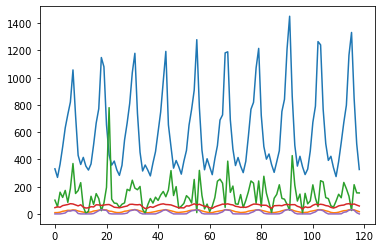

   ice_sales  avg_temp  total_rain  humidity  num_day_over25deg
0        331       9.3       101.0        46                  0
1        268       9.9        53.5        52                  0
2        365      12.7       159.5        49                  0
3        492      19.2       121.0        61                  3
4        632      22.4       172.5        65                  7


In [1]:

import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#データ読み込み　Yは最初の列に配置する
dataframe = pandas.read_csv('./kishodata/tokyo-weather-2003-2012.csv', usecols=[0,3,4,5,6], engine='python', skipfooter=1)
plt.plot(dataframe)
plt.show()
print(dataframe.head())

In [2]:
dataset = dataframe.values
#フロート型に変換
dataset = dataset.astype('float32')

# normalize the dataset
#標準化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
#後半1/3のデータを予測させるため、学習用と分ける
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

79 40


3ヶ月前までの値を使って次の月の値を学習させるので、以下のような形で整形します。
これを使う変数分作成し、1時点分のデータにそれぞれ格納します。

Y	3ヶ月前	2ヶ月前	1ヶ月前
1月の値	10月の値	11月の値	12月の値
2月の値	11月の値	12月の値	1月の値
3月の値	12月の値	1月の値	2月の値
今回は年間で1セットとみなし、ルックバックは12でデータを作ります。

In [3]:
# convert an array of values into a dataset matrix
# if you give look_back 3, a part of the array will be like this: Jan, Feb, Mar
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i:(i+look_back), j]
            xset.append(a)
        dataY.append(dataset[i + look_back, 0])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(testX.shape)
print(testX[0])
print(testY)

# reshape input to be [samples, time steps(number of variables), features] *convert time series into column
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

(27, 5, 12)
[[0.8005072  0.3846154  0.19188505 0.11327136 0.14539307 0.07945901
  0.03127643 0.0972105  0.16568047 0.40912935 0.4843618  0.79712594]
 [0.86507934 0.72222215 0.55555546 0.34523803 0.16269836 0.10714284
  0.06349203 0.19444442 0.32936507 0.5833333  0.76190466 0.92460316]
 [0.30714747 0.06374758 0.3515776  0.19059885 0.10173857 0.00708307
  0.14359304 0.18029621 0.27108824 0.14230523 0.13457824 0.0856407 ]
 [0.8461539  0.71794873 0.71794873 0.69230765 0.38461536 0.12820512
  0.61538464 0.6410256  0.6666667  0.61538464 0.79487187 0.8717949 ]
 [0.9677419  0.6774193  0.16129032 0.03225806 0.         0.
  0.         0.         0.03225806 0.2580645  0.7741935  1.        ]]
[1.         0.50380385 0.19949281 0.07016063 0.13102284 0.06593406
 0.01775149 0.05156383 0.16398987 0.34150466 0.44209638 0.8427726
 0.8224852  0.421809   0.20963651 0.10566357 0.13102284 0.0600169
 0.00507186 0.09890109 0.21639898 0.34065935 0.4480135  0.7582418
 0.8994082  0.49112424 0.20879123]


In [4]:
trainX

array([[[0.05325446, 0.        , 0.08199492, ..., 0.13693997,
         0.08030432, 0.12426037],
        [0.03968254, 0.06349203, 0.17460316, ..., 0.5198412 ,
         0.36111104, 0.19444442],
        [0.12556343, 0.0643915 , 0.2009015 , ..., 0.21635544,
         0.2910496 , 0.06374758],
        [0.2564103 , 0.41025645, 0.3333333 , ..., 0.58974355,
         0.79487187, 0.3589744 ],
        [0.        , 0.        , 0.        , ..., 0.09677419,
         0.        , 0.        ]],

       [[0.        , 0.08199492, 0.18934911, ..., 0.08030432,
         0.12426037, 0.07016063],
        [0.06349203, 0.17460316, 0.4325397 , ..., 0.36111104,
         0.19444442, 0.07142857],
        [0.0643915 , 0.2009015 , 0.15132003, ..., 0.2910496 ,
         0.06374758, 0.        ],
        [0.41025645, 0.3333333 , 0.6410256 , ..., 0.79487187,
         0.3589744 , 0.17948717],
        [0.        , 0.        , 0.09677419, ..., 0.        ,
         0.        , 0.        ]],

       [[0.08199492, 0.18934911, 0.3

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(testX.shape[1], look_back)))	#shape：変数数、遡る時間数
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
66/66 - 2s - loss: 0.0156
Epoch 2/1000
66/66 - 0s - loss: 0.0098
Epoch 3/1000
66/66 - 0s - loss: 0.0082
Epoch 4/1000
66/66 - 0s - loss: 0.0070
Epoch 5/1000
66/66 - 0s - loss: 0.0061
Epoch 6/1000
66/66 - 0s - loss: 0.0060
Epoch 7/1000
66/66 - 0s - loss: 0.0052
Epoch 8/1000
66/66 - 0s - loss: 0.0050
Epoch 9/1000
66/66 - 0s - loss: 0.0048
Epoch 10/1000
66/66 - 0s - loss: 0.0049
Epoch 11/1000
66/66 - 0s - loss: 0.0045
Epoch 12/1000
66/66 - 0s - loss: 0.0047
Epoch 13/1000
66/66 - 0s - loss: 0.0042
Epoch 14/1000
66/66 - 0s - loss: 0.0038
Epoch 15/1000
66/66 - 0s - loss: 0.0042
Epoch 16/1000
66/66 - 0s - loss: 0.0038
Epoch 17/1000
66/66 - 0s - loss: 0.0036
Epoch 18/1000
66/66 - 0s - loss: 0.0040
Epoch 19/1000
66/66 - 0s - loss: 0.0037
Epoch 20/1000
66/66 - 0s - loss: 0.0036
Epoch 21/1000
66/66 - 0s - loss: 0.0036
Epoch 22/1000
66/66 - 0s - loss: 0.0035
Epoch 23/1000
66/66 - 0s - loss: 0.0037
Epoch 24/1000
66/66 - 0s - loss: 0.0038
Epoch 25/1000
66/66 - 0s - loss: 0.0036
Epoch 26/

66/66 - 0s - loss: 7.3936e-04
Epoch 200/1000
66/66 - 0s - loss: 7.2363e-04
Epoch 201/1000
66/66 - 0s - loss: 7.2715e-04
Epoch 202/1000
66/66 - 0s - loss: 6.6988e-04
Epoch 203/1000
66/66 - 0s - loss: 6.6037e-04
Epoch 204/1000
66/66 - 0s - loss: 6.0023e-04
Epoch 205/1000
66/66 - 0s - loss: 6.8723e-04
Epoch 206/1000
66/66 - 0s - loss: 5.8227e-04
Epoch 207/1000
66/66 - 0s - loss: 6.5166e-04
Epoch 208/1000
66/66 - 0s - loss: 7.5671e-04
Epoch 209/1000
66/66 - 0s - loss: 8.6852e-04
Epoch 210/1000
66/66 - 0s - loss: 6.7252e-04
Epoch 211/1000
66/66 - 0s - loss: 7.3648e-04
Epoch 212/1000
66/66 - 0s - loss: 6.4784e-04
Epoch 213/1000
66/66 - 0s - loss: 7.9755e-04
Epoch 214/1000
66/66 - 0s - loss: 6.1729e-04
Epoch 215/1000
66/66 - 0s - loss: 5.5384e-04
Epoch 216/1000
66/66 - 0s - loss: 6.7798e-04
Epoch 217/1000
66/66 - 0s - loss: 6.7581e-04
Epoch 218/1000
66/66 - 0s - loss: 6.4259e-04
Epoch 219/1000
66/66 - 0s - loss: 6.4175e-04
Epoch 220/1000
66/66 - 0s - loss: 5.8701e-04
Epoch 221/1000
66/66 - 0s

Epoch 382/1000
66/66 - 0s - loss: 1.8276e-04
Epoch 383/1000
66/66 - 0s - loss: 2.4869e-04
Epoch 384/1000
66/66 - 0s - loss: 1.7491e-04
Epoch 385/1000
66/66 - 0s - loss: 1.8744e-04
Epoch 386/1000
66/66 - 0s - loss: 1.9988e-04
Epoch 387/1000
66/66 - 0s - loss: 1.9536e-04
Epoch 388/1000
66/66 - 0s - loss: 2.7801e-04
Epoch 389/1000
66/66 - 0s - loss: 3.8240e-04
Epoch 390/1000
66/66 - 0s - loss: 3.0573e-04
Epoch 391/1000
66/66 - 0s - loss: 1.8712e-04
Epoch 392/1000
66/66 - 0s - loss: 1.6921e-04
Epoch 393/1000
66/66 - 0s - loss: 2.1628e-04
Epoch 394/1000
66/66 - 0s - loss: 2.1369e-04
Epoch 395/1000
66/66 - 0s - loss: 2.2007e-04
Epoch 396/1000
66/66 - 0s - loss: 1.9836e-04
Epoch 397/1000
66/66 - 0s - loss: 2.0426e-04
Epoch 398/1000
66/66 - 0s - loss: 1.8774e-04
Epoch 399/1000
66/66 - 0s - loss: 1.8595e-04
Epoch 400/1000
66/66 - 0s - loss: 1.8914e-04
Epoch 401/1000
66/66 - 0s - loss: 1.7388e-04
Epoch 402/1000
66/66 - 0s - loss: 1.4599e-04
Epoch 403/1000
66/66 - 0s - loss: 1.7680e-04
Epoch 404/

66/66 - 0s - loss: 1.3427e-04
Epoch 565/1000
66/66 - 0s - loss: 9.0223e-05
Epoch 566/1000
66/66 - 0s - loss: 8.5720e-05
Epoch 567/1000
66/66 - 0s - loss: 1.3122e-04
Epoch 568/1000
66/66 - 0s - loss: 9.9971e-05
Epoch 569/1000
66/66 - 0s - loss: 1.3510e-04
Epoch 570/1000
66/66 - 0s - loss: 1.0176e-04
Epoch 571/1000
66/66 - 0s - loss: 1.0873e-04
Epoch 572/1000
66/66 - 0s - loss: 9.1656e-05
Epoch 573/1000
66/66 - 0s - loss: 1.3302e-04
Epoch 574/1000
66/66 - 0s - loss: 1.1378e-04
Epoch 575/1000
66/66 - 0s - loss: 2.6186e-04
Epoch 576/1000
66/66 - 0s - loss: 1.9578e-04
Epoch 577/1000
66/66 - 0s - loss: 1.9057e-04
Epoch 578/1000
66/66 - 0s - loss: 1.6019e-04
Epoch 579/1000
66/66 - 0s - loss: 1.0155e-04
Epoch 580/1000
66/66 - 0s - loss: 1.1154e-04
Epoch 581/1000
66/66 - 0s - loss: 1.0783e-04
Epoch 582/1000
66/66 - 0s - loss: 1.1877e-04
Epoch 583/1000
66/66 - 0s - loss: 1.0818e-04
Epoch 584/1000
66/66 - 0s - loss: 1.2293e-04
Epoch 585/1000
66/66 - 0s - loss: 8.8414e-05
Epoch 586/1000
66/66 - 0s

Epoch 747/1000
66/66 - 0s - loss: 7.6229e-05
Epoch 748/1000
66/66 - 0s - loss: 6.0646e-05
Epoch 749/1000
66/66 - 0s - loss: 6.9309e-05
Epoch 750/1000
66/66 - 0s - loss: 8.4234e-05
Epoch 751/1000
66/66 - 0s - loss: 7.6904e-05
Epoch 752/1000
66/66 - 0s - loss: 6.0029e-05
Epoch 753/1000
66/66 - 0s - loss: 7.3600e-05
Epoch 754/1000
66/66 - 0s - loss: 7.9369e-05
Epoch 755/1000
66/66 - 0s - loss: 7.5523e-05
Epoch 756/1000
66/66 - 0s - loss: 1.3114e-04
Epoch 757/1000
66/66 - 0s - loss: 1.5664e-04
Epoch 758/1000
66/66 - 0s - loss: 1.4250e-04
Epoch 759/1000
66/66 - 0s - loss: 9.9137e-05
Epoch 760/1000
66/66 - 0s - loss: 8.4853e-05
Epoch 761/1000
66/66 - 0s - loss: 6.3962e-05
Epoch 762/1000
66/66 - 0s - loss: 7.2119e-05
Epoch 763/1000
66/66 - 0s - loss: 7.0209e-05
Epoch 764/1000
66/66 - 0s - loss: 6.6327e-05
Epoch 765/1000
66/66 - 0s - loss: 9.0552e-05
Epoch 766/1000
66/66 - 0s - loss: 1.1750e-04
Epoch 767/1000
66/66 - 0s - loss: 6.8877e-05
Epoch 768/1000
66/66 - 0s - loss: 7.5128e-05
Epoch 769/

66/66 - 0s - loss: 7.6319e-05
Epoch 930/1000
66/66 - 0s - loss: 8.2446e-05
Epoch 931/1000
66/66 - 0s - loss: 5.5612e-05
Epoch 932/1000
66/66 - 0s - loss: 5.3071e-05
Epoch 933/1000
66/66 - 0s - loss: 5.5659e-05
Epoch 934/1000
66/66 - 0s - loss: 5.9800e-05
Epoch 935/1000
66/66 - 0s - loss: 8.2763e-05
Epoch 936/1000
66/66 - 0s - loss: 6.4288e-05
Epoch 937/1000
66/66 - 0s - loss: 6.6890e-05
Epoch 938/1000
66/66 - 0s - loss: 7.5967e-05
Epoch 939/1000
66/66 - 0s - loss: 8.1081e-05
Epoch 940/1000
66/66 - 0s - loss: 9.7978e-05
Epoch 941/1000
66/66 - 0s - loss: 8.5234e-05
Epoch 942/1000
66/66 - 0s - loss: 4.4468e-05
Epoch 943/1000
66/66 - 0s - loss: 4.6743e-05
Epoch 944/1000
66/66 - 0s - loss: 7.3776e-05
Epoch 945/1000
66/66 - 0s - loss: 4.6904e-05
Epoch 946/1000
66/66 - 0s - loss: 4.5472e-05
Epoch 947/1000
66/66 - 0s - loss: 5.9938e-05
Epoch 948/1000
66/66 - 0s - loss: 8.8679e-05
Epoch 949/1000
66/66 - 0s - loss: 4.2568e-05
Epoch 950/1000
66/66 - 0s - loss: 5.2697e-05
Epoch 951/1000
66/66 - 0s

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
pad_col = numpy.zeros(dataset.shape[1]-1)

# invert predictions
def pad_array(val):
    return numpy.array([numpy.insert(pad_col, 0, x) for x in val])
    
trainPredict = scaler.inverse_transform(pad_array(trainPredict))
trainY = scaler.inverse_transform(pad_array(trainY))
testPredict = scaler.inverse_transform(pad_array(testPredict))
testY = scaler.inverse_transform(pad_array(testY))

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:,0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:,0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 8.41 RMSE
Test Score: 100.22 RMSE


[1451.00000179  863.99995152  503.99999229  351.00001666  423.00001556
  345.99998981  289.00000096  329.00000427  462.0000135   672.00001322
  791.00001777 1264.99998995 1241.00000207  767.00002989  515.99998623
  392.99999546  423.00001556  338.99998747  274.00000854  384.99998774
  523.99999394  671.00000785  797.99998485 1165.00001694 1331.99992673
  848.99997673  515.00001611]
[1180.28799921  736.12918293  510.52981864  397.42903137  379.95485065
  322.23682629  294.79946097  375.87374884  453.14941597  642.32861567
  790.42463744  895.89097036 1231.08956948  813.86151413  486.04622219
  364.84864908  339.54280874  340.60774713  295.69500237  350.24750945
  496.39668675  646.08131527  770.0711929  1222.43827496 1279.55929815
  720.47975464  502.2921845 ]


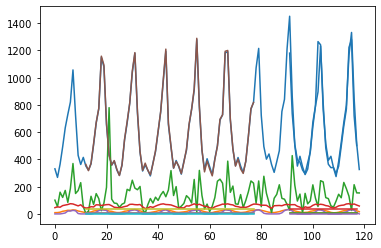

In [12]:

print(testY[:,0])
print(testPredict[:,0])
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()